In [66]:
import pandas as pd
import datetime as dt
import numpy as np
import datetime as dt
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import requests
import folium

### Creamos una función para unir todo los Datasets y agregamos columnas faltantes.

-Creamos un Datraframe con el que trabajar

In [67]:
# Función para leer y unir los datasets.
def unir_datasets(ruta):
    dfs = []

    for nombre_archivo in os.listdir(ruta):

        if nombre_archivo.endswith('.csv'):

            ruta_archivo = os.path.join(ruta, nombre_archivo)
            df = pd.read_csv(ruta_archivo, skiprows = 7, skipfooter = 1, engine = 'python') # Eliminamos las primeras filas y la última de cada dataset.

            with open(ruta_archivo, 'r') as archivo:
                segunda_fila = archivo.readlines()[1].strip() # Rescatamos información de la segunda fila de los csv's.
                coincidencia = re.search(r'Origin Airport: (.+), (.+): (.+) \((.+)\)', segunda_fila)

                if coincidencia:

                    ciudad_origen                  = coincidencia.group(1)
                    estado_origen                  = coincidencia.group(2)
                    aeropuerto_origen              = coincidencia.group(3)
                    codigo_aeropuerto_origen       = coincidencia.group(4)

                    df['ciudad_origen']            = ciudad_origen
                    df['estado_origen']            = estado_origen
                    df['aeropuerto_origen']        = aeropuerto_origen
                    df['codigo_aeropuerto_origen'] = codigo_aeropuerto_origen

                    dfs.append(df)

                else:
                    print("La segunda fila no tiene el formato esperado en el archivo:", nombre_archivo)

    resultado_df = pd.concat(dfs, ignore_index=True)
    resultado_df.to_pickle('vuelos.pkl')


ruta = r'data/' # Ruta en la que se encuentren todos los csv's.
unir_datasets(ruta)

In [68]:
df = pd.read_pickle("vuelos.pkl")

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914068 entries, 0 to 1914067
Data columns (total 21 columns):
 #   Column                                    Dtype 
---  ------                                    ----- 
 0   Carrier Code                              object
 1   Date (MM/DD/YYYY)                         object
 2   Flight Number                             int64 
 3   Tail Number                               object
 4   Destination Airport                       object
 5   Scheduled departure time                  object
 6   Actual departure time                     object
 7   Scheduled elapsed time (Minutes)          int64 
 8   Actual elapsed time (Minutes)             int64 
 9   Departure delay (Minutes)                 int64 
 10  Wheels-off time                           object
 11  Taxi-Out time (Minutes)                   int64 
 12  Delay Carrier (Minutes)                   int64 
 13  Delay Weather (Minutes)                   int64 
 14  Delay National Avi

In [70]:
df.columns

Index(['Carrier Code', 'Date (MM/DD/YYYY)', 'Flight Number', 'Tail Number',
       'Destination Airport', 'Scheduled departure time',
       'Actual departure time', 'Scheduled elapsed time (Minutes)',
       'Actual elapsed time (Minutes)', 'Departure delay (Minutes)',
       'Wheels-off time', 'Taxi-Out time (Minutes)', 'Delay Carrier (Minutes)',
       'Delay Weather (Minutes)', 'Delay National Aviation System (Minutes)',
       'Delay Security (Minutes)', 'Delay Late Aircraft Arrival (Minutes)',
       'ciudad_origen', 'estado_origen', 'aeropuerto_origen',
       'codigo_aeropuerto_origen'],
      dtype='object')

In [71]:
df.head()

,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),...,Taxi-Out time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes),ciudad_origen,estado_origen,aeropuerto_origen,codigo_aeropuerto_origen
0,MQ,12/01/2021,3632,N202NN,DFW,08:11,08:16,57,69,5,...,17,5,0,12,0,0,Abilene,TX,Abilene Regional,ABI
1,MQ,12/01/2021,3647,N653AE,DFW,06:45,06:37,56,61,-8,...,13,0,0,0,0,0,Abilene,TX,Abilene Regional,ABI
2,MQ,12/01/2021,3723,N616AE,DFW,14:47,14:38,54,67,-9,...,13,0,0,0,0,0,Abilene,TX,Abilene Regional,ABI
3,MQ,12/01/2021,4192,N681AE,DFW,12:35,12:35,61,59,0,...,9,0,0,0,0,0,Abilene,TX,Abilene Regional,ABI
4,MQ,12/01/2021,4311,N687JS,DFW,18:36,19:47,62,58,71,...,12,4,0,0,0,63,Abilene,TX,Abilene Regional,ABI


In [72]:
# RENOMBRAMOS LAS COLUMNAS PARA QUE SEAN MÁS EXPLICATIVAS 

df.rename(columns={ 
    'Carrier Code'                            : 'aerolinea',
    'Date (MM/DD/YYYY)'                       : 'fecha',
    'Flight Number'                           : 'numero_vuelo',
    'Tail Number'                             : 'numero_cola',
    'Destination Airport'                     : 'codigo_aeropuerto_destino',
    'Scheduled departure time'                : 'hora_salida_programada',
    'Actual departure time'                   : 'hora_salida_real',
    'Scheduled elapsed time (Minutes)'        : 'duracion_programada_vuelo',
    'Actual elapsed time (Minutes)'           : 'duracion_real',
    'Departure delay (Minutes)'               : 'retraso_salida',
    'Wheels-off time'                         : 'hora_despegue',
    'Taxi-Out time (Minutes)'                 : 'tiempo_pista_salida',
    'Delay Carrier (Minutes)'                 : 'tiempo_retraso_aerolinea',
    'Delay Weather (Minutes)'                 : 'tiempo_retraso_clima',
    'Delay National Aviation System (Minutes)': 'tiempo_retraso_sistema_aviacion',
    'Delay Security (Minutes)'                : 'tiempo_retraso_seguridad',
    'Delay Late Aircraft Arrival (Minutes)'   : 'retraso_llegada'
}, inplace= True)

## Columnas del Dataframe


- **aerolinea**: Nombre de la aerolínea.
- **fecha**: La fecha del vuelo en formato día/mes/año.
- **numero_vuelo**: El número de vuelo.
- **numero_cola**: El número de cola del vuelo.
- **aeropuerto_destino**: El aeropuerto de destino del vuelo. 
- **hora_salida_programada**: La hora programada de salida del vuelo.
- **hora_salida_real**: La hora real de salida del vuelo.
- **duracion_programada_vuelo**: La duración programada del vuelo.
- **duracion_real**: La duración real del vuelo.
- **retraso_salida**: El retraso en la salida del vuelo.
- **hora_despegue**: La hora de despegue del vuelo.
- **tiempo_pista_salida**: El tiempo en pista antes del despegue.
- **tiempo_retraso_aerolinea**: Tiempo de retraso atribuido a la aerolínea.
- **tiempo_retraso_clima**: Tiempo de retraso atribuido al clima.
- **tiempo_retraso_sistema_aviacion**: Tiempo de retraso atribuido al sistema de aviación.
- **tiempo_retraso_seguridad**: Tiempo de retraso atribuido a cuestiones de seguridad.
- **retraso_llegada_aeronave**: Retraso en la llegada de la aeronave.
- **ciudad_origen**: La ciudad de origen del vuelo.
- **estado_origen**: El estado de origen del vuelo.
- **aeropuerto_origen**: El aeropuerto de origen del vuelo.
- **dia_semana**: El día de la semana en que tuvo lugar el vuelo.
- **año**: El año en que tuvo lugar el vuelo.
- **fin_de_semana**: Indicador de si el vuelo tuvo lugar durante el fin de semana o no.
- **festivos**: Indicador de si el vuelo tuvo lugar en un día festivo o no.
- **distancia_millas**: La distancia del vuelo en millas.
- **ciudad_destino**: La ciudad de destino del vuelo.
- **estado_destino**: El estado de destino del vuelo.

In [73]:
# RENOMBRAMOS LOS CÓDIGOS DE LAS AEROLÍNEAS

aerolineas = {
    'MQ': 'Envoy Air',
    'OO': 'SkyWest Airlines',
    'OH': 'PSA Airlines',
    '9E': 'Endeavor Air',
    'YV': 'Mesa Airlines',
    'WN': 'Southwest Airlines',
    'G4': 'Allegiant Air',
    'AA': 'American Airlines',
    'DL': 'Delta Air Lines',
    'F9': 'Frontier Airlines',
    'B6': 'JetBlue Airways',
    'YX': 'Republic Airways',
    'UA': 'United Airlines',
    'AS': 'Alaska Airlines',
    'HA': 'Hawaiian Airlines',
    'QX': 'Horizon Air',
    'NK': 'Spirit Airlines'
}

df['aerolinea'] = df['aerolinea'].replace(aerolineas)

### Buscamos y eliminamos duplicados.

In [74]:
duplicados = df.duplicated()

if duplicados.any():
    print("El DataFrame tiene filas duplicadas.")
else:
    print("El DataFrame no tiene filas duplicadas.")

num_filas_duplicadas = df.duplicated().sum()

print("Número de filas duplicadas:", num_filas_duplicadas)

El DataFrame tiene filas duplicadas.
Número de filas duplicadas: 221448


In [75]:
df.shape

(1914068, 21)

In [76]:
df.drop_duplicates(inplace=True)
df.shape

(1692620, 21)

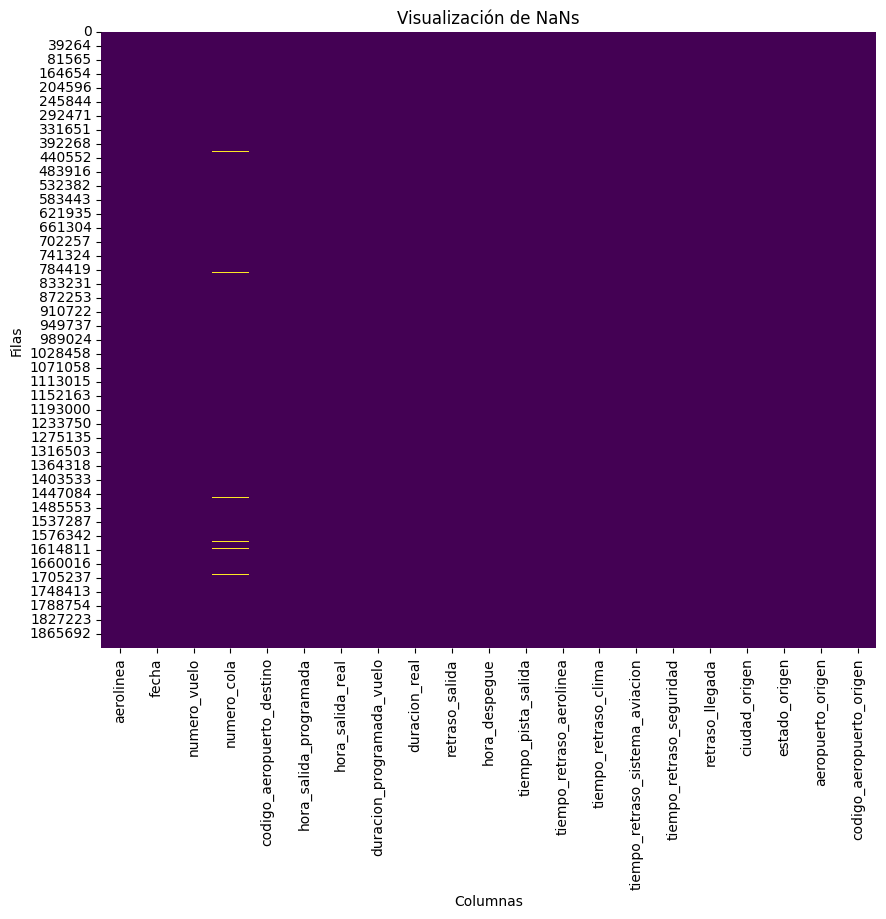

In [77]:
# fig = px.imshow(df.isna(), labels=dict(x="Columnas", y="Filas"), x=df.columns, y=df.index)

# fig.update_layout(
#     title='Visualización de NaNs'
# )

# fig.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title('Visualización de NaNs')
plt.xlabel('Columnas')
plt.ylabel('Filas')
plt.show()

In [78]:
# Calcular el porcentaje de Nan's que existe por columnas.
df.isna().sum()/len(df)*100

aerolinea                          0.000000
fecha                              0.000000
numero_vuelo                       0.000000
numero_cola                        0.649821
codigo_aeropuerto_destino          0.000000
hora_salida_programada             0.000000
hora_salida_real                   0.000000
duracion_programada_vuelo          0.000000
duracion_real                      0.000000
retraso_salida                     0.000000
hora_despegue                      0.000000
tiempo_pista_salida                0.000000
tiempo_retraso_aerolinea           0.000000
tiempo_retraso_clima               0.000000
tiempo_retraso_sistema_aviacion    0.000000
tiempo_retraso_seguridad           0.000000
retraso_llegada                    0.000000
ciudad_origen                      0.000000
estado_origen                      0.000000
aeropuerto_origen                  0.000000
codigo_aeropuerto_origen           0.000000
dtype: float64

Observamos la prensencia de Nan's en la columna `numero_cola`

In [79]:
# Existe relación con los números de cola con algunos número de vuelo, creamos una función para buscar el número 
# de cola asociado al número de vuelo de esa fila en el diccionario y reemplazamos los NaN

def rellenar_numero_cola_relacionado(df):

    vuelo_a_cola = dict(zip(df['numero_vuelo'], df['numero_cola']))

    def rellenar(fila):

        if pd.isnull(fila['numero_cola']):

            return vuelo_a_cola.get(fila['numero_vuelo'], pd.NA)
        
        else:

            return fila['numero_cola']

    df['numero_cola'] = df.apply(rellenar, axis = 1)

    return df

df_prueba = rellenar_numero_cola_relacionado(df)

In [80]:
# Contamos el número de filas sin rellenar.
nan_cola = df['numero_cola'].isna().sum()

print(f'Quedan sin rellenar {nan_cola} filas en la columna `numero_cola`.')

# Las que no se rellenan las eliminamos. 
df.dropna(subset=['numero_cola'], inplace=True)

Quedan sin rellenar 144 filas en la columna `numero_cola`.


`numero_cola`: Número de cola de la aeronave.

La columna `numero_cola` contiene números de registro, son asignados por la Administración Federal de Aviación (FAA) en los Estados Unidos y se utilizan para identificar de manera única a cada aeronave registrada en EEUU.

- La letra inicial 'N' indica que la aeronave está registrada en EEUU.
- La letra inicial 'S' indica que se trata de una aeronave ultraligera.

Luego, los números y las letras restantes forman un identificador único para esa aeronave específica.

In [81]:
# Comprobamos si todos son de origen estadounidense.
df['numero_cola_inicio'] = df['numero_cola'].apply(lambda x: x[0] if isinstance(x, str) else None)

print(df['numero_cola_inicio'].unique())

df.drop(columns = 'numero_cola_inicio', axis = 1, inplace = True)

['N' '3' '2' '1' 'S']


Vemos que no todos los vuelos tiene N en el número de cola, así que no todos son de origen estadounidense.

### Agregamos y modificamos las columnas referentes a fechas y horas.

- `hora_salida_real`, `hora_salida_programada`, `hora_llegada_real`, `fecha`, `dia_semana`, `anio`, `fin_de_semana`, `festivos`.

In [82]:
# Cambiamos a DATETIME las columnas 'hora_salida_real' y 'hora_salida_programada'.
df['hora_salida_real'] = df['hora_salida_real'].replace({'24:00' : '00:00'})

df['hora_salida_real'] = pd.to_datetime(df['hora_salida_real'], format = '%H:%M').dt.time
df['hora_salida_programada'] = pd.to_datetime(df['hora_salida_programada'], format='%H:%M').dt.time

In [83]:
# Sumamos la duración real al tiempo de salida real para obtener la hora de llegada.

df['hora_llegada_real'] = pd.to_timedelta(df['hora_salida_real'].astype(str)) + pd.to_timedelta(df['duracion_real'], unit='m')

In [84]:
# Volvemos a convertir la columna 'hora_llegada_real a datetime.
df['hora_llegada_real'] = df['hora_llegada_real'].astype(str)

# Si deseas eliminar los microsegundos, puedes hacerlo así
df['hora_llegada_real'] = df['hora_llegada_real'].str.split('.').str[0]
df['hora_llegada_real'] = df['hora_llegada_real'].str.split(' ').str[2]

df['hora_llegada_real'] = pd.to_datetime(df['hora_llegada_real']).dt.time

C:\Users\34670\AppData\Local\Temp\ipykernel_13368\1979438147.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['hora_llegada_real'] = pd.to_datetime(df['hora_llegada_real']).dt.time


In [85]:
# Cambiamos a DATETIME la columna 'fecha'.
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

# Agregamos las columnas año, día de la semana, mes y fin de semana.

df['dia_semana'] = df['fecha'].dt.dayofweek
df['anio'] = df['fecha'].dt.year
df['mes'] = df['fecha'].dt.month
df['fin_de_semana'] = (df['fecha'].dt.dayofweek >= 5).astype(int)

In [86]:
# Agregamos el pkl con los días festivos, quitando las columnas innecesarias.
df_festivos = pd.read_pickle(r"C:/Users/34670/Desktop/python/Hack a boss/proyecto_3/streamlit/proyecto_aviones/data/fecha_festivos.pkl")

eliminar_columnas = ['dia', 'mes', 'ano']
df_festivos.drop(eliminar_columnas, axis = 1, inplace = True)

df_festivos.tail()

,festivos
50,2023-09-04
51,2023-10-09
52,2023-11-10
53,2023-11-23
54,2023-12-25


In [87]:
# Agregamos al df los días festivos de EEUU.
df = df.merge(df_festivos, left_on = 'fecha', right_on = 'festivos', how = 'left')

df['festivos'] = df['festivos'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [88]:
# Comprobamos que la columna se agrega bien.
prueba_fecha = df[df['fecha'] == '2023-12-25'] # Fecha festiva (Navidad).
prueba_fecha.head()

,aerolinea,fecha,numero_vuelo,numero_cola,codigo_aeropuerto_destino,hora_salida_programada,hora_salida_real,duracion_programada_vuelo,duracion_real,retraso_salida,...,ciudad_origen,estado_origen,aeropuerto_origen,codigo_aeropuerto_origen,hora_llegada_real,dia_semana,anio,mes,fin_de_semana,festivos
330,Envoy Air,2023-12-25,3405,N302RN,DFW,18:07:00,18:02:00,57,44,-5,...,Abilene,TX,Abilene Regional,ABI,18:46:00,0,2023,12,0,1
331,Envoy Air,2023-12-25,3407,N202NN,DFW,10:37:00,10:17:00,57,46,-20,...,Abilene,TX,Abilene Regional,ABI,11:03:00,0,2023,12,0,1
332,Envoy Air,2023-12-25,3408,N282NN,DFW,14:08:00,13:49:00,56,62,-19,...,Abilene,TX,Abilene Regional,ABI,14:51:00,0,2023,12,0,1
333,Envoy Air,2023-12-25,3647,N764JD,DFW,08:14:00,08:13:00,59,64,-1,...,Abilene,TX,Abilene Regional,ABI,09:17:00,0,2023,12,0,1
334,Envoy Air,2023-12-25,3706,N635RW,DFW,06:00:00,05:54:00,59,47,-6,...,Abilene,TX,Abilene Regional,ABI,06:41:00,0,2023,12,0,1


### Agregamos columnas referentes a los nombres de los aeropuertos de origen y destino.

- `codigo_aeropuerto_origen`, `codigo_aeropuerto_destino`.

In [89]:
# Los códigos de aeropuerto de origen y destino coinciden menos en uno.
lista_codigo_aeropuerto_destino = sorted(df["codigo_aeropuerto_destino"].unique())
lista_codigo_aeropuerto_origen = sorted(df["codigo_aeropuerto_origen"].unique())

print(lista_codigo_aeropuerto_destino)
print(f'Número total de aeropuertos de destino: {len(lista_codigo_aeropuerto_destino)}\n')

print(lista_codigo_aeropuerto_origen)
print(f'Número total de aeropuertos de origen: {len(lista_codigo_aeropuerto_origen)}')

['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACT', 'ACV', 'ACY', 'ADK', 'ADQ', 'AEX', 'AGS', 'AKN', 'ALB', 'ALO', 'ALS', 'ALW', 'AMA', 'ANC', 'APN', 'ASE', 'ATL', 'ATW', 'ATY', 'AUS', 'AVL', 'AVP', 'AZA', 'AZO', 'BDL', 'BET', 'BFF', 'BFL', 'BGM', 'BGR', 'BHM', 'BIH', 'BIL', 'BIS', 'BJI', 'BLI', 'BLV', 'BMI', 'BNA', 'BOI', 'BOS', 'BPT', 'BQK', 'BQN', 'BRD', 'BRO', 'BRW', 'BTM', 'BTR', 'BTV', 'BUF', 'BUR', 'BWI', 'BZN', 'CAE', 'CAK', 'CDC', 'CDV', 'CGI', 'CHA', 'CHO', 'CHS', 'CID', 'CIU', 'CKB', 'CLE', 'CLL', 'CLT', 'CMH', 'CMI', 'CMX', 'CNY', 'COD', 'COS', 'COU', 'CPR', 'CRP', 'CRW', 'CSG', 'CVG', 'CWA', 'CYS', 'DAB', 'DAL', 'DAY', 'DBQ', 'DCA', 'DDC', 'DEC', 'DEN', 'DFW', 'DHN', 'DIK', 'DLG', 'DLH', 'DRO', 'DRT', 'DSM', 'DTW', 'DVL', 'EAR', 'EAT', 'EAU', 'ECP', 'EGE', 'EKO', 'ELM', 'ELP', 'ERI', 'ESC', 'EUG', 'EVV', 'EWN', 'EWR', 'EYW', 'FAI', 'FAR', 'FAT', 'FAY', 'FCA', 'FLG', 'FLL', 'FNT', 'FOD', 'FSD', 'FSM', 'FWA', 'GCC', 'GCK', 'GEG', 'GFK', 'GGG', 'GJT', 'GNV', 'GPT', 'GRB', 'GRI', 'GRK'

In [90]:
# El valor que aparece de más en codigo_aeropuerto_destino es 'GCK'.
# GCK es el código de aeropuerto para el Aeropuerto de Garden City, ubicado en Garden City, Kansas, Estados Unidos.

codigo_faltante_aeropuerto_destino = set(lista_codigo_aeropuerto_destino) - set(lista_codigo_aeropuerto_origen)
codigo_faltante_aeropuerto_destino

{'GCK'}

In [91]:
lista_aeropuerto_origen = sorted(df["aeropuerto_origen"].unique())

print(lista_aeropuerto_origen)
print(f'Aparecen {len(lista_aeropuerto_origen)} aeropuertos.')

['Aberdeen Regional', 'Abilene Regional', 'Abraham Lincoln Capital', 'Adak', 'Akron-Canton Regional', 'Albany International', 'Albert J Ellis', 'Albuquerque International Sunport', 'Alexandria International', 'Alpena County Regional', 'Appleton International', 'Arnold Palmer Regional', 'Asheville Regional', 'Aspen Pitkin County Sardy Field', 'Atlantic City International', 'Augusta Regional at Bush Field', 'Austin - Bergstrom International', 'Baltimore/Washington International Thurgood Marshall', 'Bangor International', 'Barkley Regional', 'Baton Rouge Metropolitan/Ryan Field', 'Bellingham International', 'Bemidji Regional', 'Bert Mooney', 'Bethel Airport', 'Bill and Hillary Clinton Nat Adams Field', 'Billings Logan International', 'Birmingham-Shuttlesworth International', 'Bishop Airport', 'Bishop International', 'Bismarck Municipal', 'Blue Grass', 'Bob Hope', 'Boise Air Terminal', 'Bozeman Yellowstone International', 'Bradley International', 'Brainerd Lakes Regional', 'Brownsville Sou

In [92]:
aeropuertos_agrupado = df.groupby(['aeropuerto_origen', 'codigo_aeropuerto_origen']).size().reset_index()

# El código correcto del aeropuerto Tri Cities	es PSC.
codigo_no_coincidente = aeropuertos_agrupado[aeropuertos_agrupado.duplicated(subset=['aeropuerto_origen'], keep=False)]

codigo_no_coincidente

,aeropuerto_origen,codigo_aeropuerto_origen,0
328,Tri Cities,PSC,1416
329,Tri Cities,TRI,670


In [93]:
# Asignamos a todos PSC.

df.loc[df['aeropuerto_origen'] == 'Tri Cities', 'codigo_aeropuerto_origen'] = 'PSC'

In [94]:
# Se realiza correctamente.

df[df['aeropuerto_origen'] == 'Tri Cities']

,aerolinea,fecha,numero_vuelo,numero_cola,codigo_aeropuerto_destino,hora_salida_programada,hora_salida_real,duracion_programada_vuelo,duracion_real,retraso_salida,...,ciudad_origen,estado_origen,aeropuerto_origen,codigo_aeropuerto_origen,hora_llegada_real,dia_semana,anio,mes,fin_de_semana,festivos
519897,Alaska Airlines,2023-12-01,1023,N320AS,SEA,08:00:00,07:56:00,75,105,-4,...,Pasco/Kennewick/Richland,WA,Tri Cities,PSC,09:41:00,4,2023,12,0,0
519898,Alaska Airlines,2023-12-02,1023,N309AS,SEA,08:00:00,08:00:00,75,61,0,...,Pasco/Kennewick/Richland,WA,Tri Cities,PSC,09:01:00,5,2023,12,1,0
519899,Alaska Airlines,2023-12-03,1023,N464AS,SEA,08:00:00,07:58:00,75,71,-2,...,Pasco/Kennewick/Richland,WA,Tri Cities,PSC,09:09:00,6,2023,12,1,0
519900,Alaska Airlines,2023-12-04,1023,N435AS,SEA,08:00:00,07:53:00,75,63,-7,...,Pasco/Kennewick/Richland,WA,Tri Cities,PSC,08:56:00,0,2023,12,0,0
519901,Alaska Airlines,2023-12-05,1023,N251AK,SEA,08:00:00,07:54:00,75,63,-6,...,Pasco/Kennewick/Richland,WA,Tri Cities,PSC,08:57:00,1,2023,12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059604,SkyWest Airlines,2021-12-29,3096,N604SK,DFW,17:40:00,17:37:00,183,185,-3,...,Bristol/Johnson City/Kingsport,TN,Tri Cities,PSC,20:42:00,2,2021,12,0,0
1059605,SkyWest Airlines,2021-12-30,2984,N708EV,DFW,05:36:00,05:31:00,184,170,-5,...,Bristol/Johnson City/Kingsport,TN,Tri Cities,PSC,08:21:00,3,2021,12,0,0
1059606,SkyWest Airlines,2021-12-30,3096,N708EV,DFW,17:40:00,17:37:00,183,161,-3,...,Bristol/Johnson City/Kingsport,TN,Tri Cities,PSC,20:18:00,3,2021,12,0,0
1059607,SkyWest Airlines,2021-12-31,2984,N753EV,DFW,05:36:00,05:24:00,184,159,-12,...,Bristol/Johnson City/Kingsport,TN,Tri Cities,PSC,08:03:00,4,2021,12,0,0


In [95]:
# Creamos un diccinoario con los aeropuertos.
diccionario_aeropuertos = dict(zip(aeropuertos_agrupado['codigo_aeropuerto_origen'], aeropuertos_agrupado['aeropuerto_origen']))

# Agregamos el que faltaba.
diccionario_aeropuertos['GCK'] = 'Garden City'

print(diccionario_aeropuertos)

{'ABR': 'Aberdeen Regional', 'ABI': 'Abilene Regional', 'SPI': 'Abraham Lincoln Capital', 'ADK': 'Adak', 'CAK': 'Akron-Canton Regional', 'ALB': 'Albany International', 'OAJ': 'Albert J Ellis', 'ABQ': 'Albuquerque International Sunport', 'AEX': 'Alexandria International', 'APN': 'Alpena County Regional', 'ATW': 'Appleton International', 'LBE': 'Arnold Palmer Regional', 'AVL': 'Asheville Regional', 'ASE': 'Aspen Pitkin County Sardy Field', 'ACY': 'Atlantic City International', 'AGS': 'Augusta Regional at Bush Field', 'AUS': 'Austin - Bergstrom International', 'BWI': 'Baltimore/Washington International Thurgood Marshall', 'BGR': 'Bangor International', 'PAH': 'Barkley Regional', 'BTR': 'Baton Rouge Metropolitan/Ryan Field', 'BLI': 'Bellingham International', 'BJI': 'Bemidji Regional', 'BTM': 'Bert Mooney', 'BET': 'Bethel Airport', 'LIT': 'Bill and Hillary Clinton Nat Adams Field', 'BIL': 'Billings Logan International', 'BHM': 'Birmingham-Shuttlesworth International', 'BIH': 'Bishop Airpor

In [96]:
# Creamos una nueva columna con los nombres de los aeropuertos de destino.
df['aeropuerto_destino'] = df['codigo_aeropuerto_destino'].replace(diccionario_aeropuertos)

# A aeropuerto destino también le cambiamos el valor del código para que no tenga dos
df.loc[df['aeropuerto_destino'] == 'Tri Cities', 'codigo_aeropuerto_destino'] = 'PSC'

In [97]:
df["codigo_aeropuerto_destino"].nunique()

363

In [98]:
df["codigo_aeropuerto_origen"].nunique()

362

AGREGAMOS LAS COLUMNAS `ciudad_destino` y `estado_destino`.

In [99]:
# Utilizamos la columna aeropuerto_origen como referencia para agregar las nuevas columnas.

ciudad_origen_agrupado = df.groupby(['aeropuerto_origen', 'ciudad_origen']).size().reset_index()
estado_origen_agrupado = df.groupby(['aeropuerto_origen', 'estado_origen']).size().reset_index()

In [100]:
# Creamos dos diccionarios donde se relacionan los aeropuertos con las ciudades y los estados.

diccionario_ciudades = dict(zip(ciudad_origen_agrupado['aeropuerto_origen'], ciudad_origen_agrupado['ciudad_origen']))
diccionario_estados = dict(zip(estado_origen_agrupado['aeropuerto_origen'], estado_origen_agrupado['estado_origen']))

In [101]:
# Relacionamos el aeropuerto destino con la ciudad y el estado destino.

df['ciudad_destino'] = df['aeropuerto_destino'].replace(diccionario_ciudades)
df['estado_destino'] = df['aeropuerto_destino'].replace(diccionario_estados)

In [43]:
# No tenemos datos de salidas de este aeropuerto

aeropuerto_faltante = set(df['aeropuerto_destino']) - set(df['aeropuerto_origen'])

print("Aeropuerto destino del que no salen aviones:", aeropuerto_faltante)

Aeropuerto destino del que no salen aviones: {'Garden City'}


### Ahora vamos a proceder a una búsqueda exhaustiva de las coordenadas (latitud y altitud) y dirección de los aeropuertos de origen y destino, así como las distancias entre los mismos (en millas).

In [102]:
print(df.columns)

Index(['aerolinea', 'fecha', 'numero_vuelo', 'numero_cola',
       'codigo_aeropuerto_destino', 'hora_salida_programada',
       'hora_salida_real', 'duracion_programada_vuelo', 'duracion_real',
       'retraso_salida', 'hora_despegue', 'tiempo_pista_salida',
       'tiempo_retraso_aerolinea', 'tiempo_retraso_clima',
       'tiempo_retraso_sistema_aviacion', 'tiempo_retraso_seguridad',
       'retraso_llegada', 'ciudad_origen', 'estado_origen',
       'aeropuerto_origen', 'codigo_aeropuerto_origen', 'hora_llegada_real',
       'dia_semana', 'anio', 'mes', 'fin_de_semana', 'festivos',
       'aeropuerto_destino', 'ciudad_destino', 'estado_destino'],
      dtype='object')


**Lo primero que vamos a hacer para buscar las coordenadas es crear un df con aeropuertos únicos**

In [46]:
valores_unicos_aeropuertos = df['aeropuerto_destino'].unique()
print(valores_unicos_aeropuertos)

print(f"Número de aeropuertos únicos: {len(valores_unicos_aeropuertos)}")

['Dallas/Fort Worth International' "Chicago O'Hare International"
 'Charlotte Douglas International' 'Ronald Reagan Washington National'
 'Philadelphia International' 'Hartsfield-Jackson Atlanta International'
 'William P Hobby' 'Baltimore/Washington International Thurgood Marshall'
 'Orlando International' 'Nashville International'
 'Cincinnati/Northern Kentucky International' 'Indianapolis International'
 'Pittsburgh International' 'Bishop International'
 'Washington Dulles International' 'Norfolk International'
 'Miami International' 'Austin - Bergstrom International'
 'Phoenix Sky Harbor International' 'Charlottesville Albemarle'
 'Shreveport Regional' 'Springfield-Branson National' 'Valdosta Regional'
 'Albert J Ellis' 'Baton Rouge Metropolitan/Ryan Field'
 'Central Il Regional Airport at Bloomington' 'Key West International'
 'Blue Grass' 'West Virginia International Yeager' 'Lovell Field'
 'Southwest Georgia Regional' 'Dothan Regional'
 'Augusta Regional at Bush Field' 'Lehigh V

In [47]:
df_origen = df[['aeropuerto_origen', 'ciudad_origen', 'estado_origen']].copy()
df_destino = df[['aeropuerto_destino']].copy()
df_destino.columns = ['aeropuerto_origen']

df_destino['ciudad_origen'] = None
df_destino['estado_origen'] = None
df_aeropuertos_concatenados = pd.concat([df_origen, df_destino])

df_aeropuertos_unicos = df_aeropuertos_concatenados.drop_duplicates(subset=['aeropuerto_origen'])
df_aeropuertos_unicos.reset_index(drop=True, inplace=True)


print(df_aeropuertos_unicos)

                            aeropuerto_origen      ciudad_origen estado_origen
0                            Abilene Regional            Abilene            TX
1                       Akron-Canton Regional              Akron            OH
2    Hartsfield-Jackson Atlanta International            Atlanta            GA
3    Jackson Medgar Wiley Evers International  Jackson/Vicksburg            MS
4                  Jacksonville International       Jacksonville            FL
..                                        ...                ...           ...
358                     Long Island MacArthur              Islip            NY
359             Ithaca Tompkins International    Ithaca/Cortland            NY
360                              Jackson Hole            Jackson            WY
361                         Aberdeen Regional           Aberdeen            SD
362                               Garden City               None          None

[363 rows x 3 columns]


Buscamos donde está Garden City en Google y le indicamos ciudad y estado


In [48]:
# Garden City que es el único que aparece como none...
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['aeropuerto_origen'] == "Garden City", 'ciudad_origen'] = "Garden City"
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['aeropuerto_origen'] == "Garden City", 'estado_origen'] = "KS"

print(df_aeropuertos_unicos[df_aeropuertos_unicos['aeropuerto_origen'] == "Garden City"])


    aeropuerto_origen ciudad_origen estado_origen
362       Garden City   Garden City            KS


In [49]:
# Cambiamos el nombre de las columnas para que sea más cómodo

df_aeropuertos_unicos.rename(columns={
    'aeropuerto_origen': 'nombre_aeropuerto',
    'ciudad_origen': 'ciudad',
    'estado_origen': 'estado'
}, inplace=True)

print(df_aeropuertos_unicos.columns)

Index(['nombre_aeropuerto', 'ciudad', 'estado'], dtype='object')


C:\Users\34670\AppData\Local\Temp\ipykernel_13368\699129843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aeropuertos_unicos.rename(columns={


## Ahora vamos a utilizar la API de foursquare para buscar las coordenadas.
Como tenemos el nombre del aeropuerto, la ciudad y el estado... vamos a buscar aeropuertos y que nos devuelva latitud y longitud

In [52]:
# API de Foursquare
CLIENT_ID = "QCDWZLNWZBWTQKPLJLC2GCFIGRICGGQX1D1AJD1JUM0FMUPU"
CLIENT_SECRET = "NVRHLER4BNQ2LHGUEWDFPAIF132KBCT2JHQU5X35MLCS1S0B"
API_KEY = "fsq3gHQLqKS5DaSzw9RzKUqjuW9Ec14h06kJE5xVxKSHAfg="

headers = {"Accept": "application/json", "Authorization": API_KEY}

df_aeropuertos_unicos['latitude'] = None
df_aeropuertos_unicos['longitude'] = None
df_aeropuertos_unicos['direccion'] = None

for index, row in df_aeropuertos_unicos.iterrows():
    url_params = {
        "query": "airport" + row['nombre_aeropuerto'],
        "near": f"{row['ciudad']}, {row['estado']}", 'USA'
        "limit": 1
    }

    
    response = requests.get(url="https://api.foursquare.com/v3/places/search", params=url_params, headers=headers)

    
    if response.status_code == 200:
        data = response.json()
        
        if data['results']:
            result = data['results'][0] 
            latitude = result['geocodes']['main']['latitude']
            longitude = result['geocodes']['main']['longitude']
            direccion = result['location']['formatted_address']
           
            df_aeropuertos_unicos.at[index, 'latitude'] = latitude
            df_aeropuertos_unicos.at[index, 'longitude'] = longitude
            df_aeropuertos_unicos.at[index, 'direccion'] = direccion
    else:
        print(f"Error en la fila {index} con el aeropuerto {row['nombre_aeropuerto']}. Respuesta: {response.status_code}")




print(df_aeropuertos_unicos.head())


C:\Users\34670\AppData\Local\Temp\ipykernel_13368\1979432522.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aeropuertos_unicos['latitude'] = None
C:\Users\34670\AppData\Local\Temp\ipykernel_13368\1979432522.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aeropuertos_unicos['longitude'] = None
C:\Users\34670\AppData\Local\Temp\ipykernel_13368\1979432522.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

                          nombre_aeropuerto             ciudad estado  \
0                          Abilene Regional            Abilene     TX   
1                     Akron-Canton Regional              Akron     OH   
2  Hartsfield-Jackson Atlanta International            Atlanta     GA   
3  Jackson Medgar Wiley Evers International  Jackson/Vicksburg     MS   
4                Jacksonville International       Jacksonville     FL   

    latitude  longitude                                          direccion  
0   32.45095 -99.735678        202 Cedar St (North 2nd), Abilene, TX 79601  
1  41.080564 -81.519677                     182 S Main St, Akron, OH 44308  
2  33.640846 -84.432594  6000 N Terminal Pkwy (at Airport Loop Rd), Atl...  
3  32.353325 -90.880255                 923 Walnut St, Vicksburg, MS 39183  
4  30.328992 -81.657959  303 N Laura St (Duval St.), Jacksonville, FL 3...  


In [53]:
#Es posible que falte algún dato por pruebas anteriores que hemos realizado, por lo tanto ejecutamos una segunda prueba buscando en los datos que no tienen aún

for index, row in df_aeropuertos_unicos.iterrows():    
    if pd.isnull(row['latitude']) or pd.isnull(row['longitude']) or pd.isnull(row['direccion']):        
        url_params['query'] = row['nombre_aeropuerto'] + " airport"

        
        response = requests.get(url="https://api.foursquare.com/v3/places/search", params=url_params, headers=headers)

        
        if response.status_code == 200:
            data = response.json()

            

            if data['results']:
                result = data['results'][0]  
                latitude = result['geocodes']['main']['latitude']
                longitude = result['geocodes']['main']['longitude']
                direccion = result['location']['formatted_address']

                
                df_aeropuertos_unicos.at[index, 'latitude'] = latitude
                df_aeropuertos_unicos.at[index, 'longitude'] = longitude
                df_aeropuertos_unicos.at[index, 'direccion'] = direccion
        else:
            print(f"Error en la segunda búsqueda en la fila {index} con el aeropuerto {row['nombre_aeropuerto']}. Respuesta: {response.status_code}")



print(df_aeropuertos_unicos.head())


                          nombre_aeropuerto             ciudad estado  \
0                          Abilene Regional            Abilene     TX   
1                     Akron-Canton Regional              Akron     OH   
2  Hartsfield-Jackson Atlanta International            Atlanta     GA   
3  Jackson Medgar Wiley Evers International  Jackson/Vicksburg     MS   
4                Jacksonville International       Jacksonville     FL   

    latitude  longitude                                          direccion  
0   32.45095 -99.735678        202 Cedar St (North 2nd), Abilene, TX 79601  
1  41.080564 -81.519677                     182 S Main St, Akron, OH 44308  
2  33.640846 -84.432594  6000 N Terminal Pkwy (at Airport Loop Rd), Atl...  
3  32.353325 -90.880255                 923 Walnut St, Vicksburg, MS 39183  
4  30.328992 -81.657959  303 N Laura St (Duval St.), Jacksonville, FL 3...  


In [54]:
nulos_latitude = df_aeropuertos_unicos['latitude'].isnull().sum()
nulos_longitude = df_aeropuertos_unicos['longitude'].isnull().sum()

print(f"Valores nulos en 'latitude': {nulos_latitude}")
print(f"Valores nulos en 'longitude': {nulos_longitude}")

Valores nulos en 'latitude': 0
Valores nulos en 'longitude': 0


**Vamos a hacer una comprobación gráfica para ver si a simple vista vemos algún error en las coordenadas... por ejemplo si alguna la ha puesto en medio del mar o en algún país de África por ejemplo...**

In [56]:
# mapa folium usa
mapa = folium.Map(location=[40, -95], zoom_start=4)

# los marcadores, hay que cambiarlos
for index, row in df_aeropuertos_unicos.iterrows():
    folium.Marker(
        [row['latitude'], row['longitude']], 
        popup=f"{row['nombre_aeropuerto']}", 
        tooltip=row['nombre_aeropuerto']
    ).add_to(mapa)

mapa

**Como podemos ver en el mapa nos situa algún aeropuerto en Ciudad de México o en Tribinidad y Tobago por ejemplo...**
Si que es verdad que hay aeropuertos que tenemos que localizar que no están en territorio de Estados Unidos como puede ser Guam o Samoa Americana... ahora veremos eso más adelante

In [57]:
# Lo tenemos que hacer de forma manual. Algunos eran muy claros... otros hemos investigado un poco a ver si había algo raro

df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Dallas/Fort Worth International', 'latitude'] = 32.897480
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Dallas/Fort Worth International', 'longitude'] = -97.040443

direccion_dallas_fort_worth = "2400 Aviation Dr, DFW Airport, TX 75261, USA"  
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Dallas/Fort Worth International Airport', 'direccion'] = direccion_dallas_fort_worth

df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Ellison Onizuka Kona International at Keahole', 'latitude'] = 19.738889
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Ellison Onizuka Kona International at Keahole', 'longitude'] = -156.045556
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Ellison Onizuka Kona International at Keahole', 'estado'] = 'HI'

direccion_ellison = "73-200 Kupipi St, Kailua-Kona, HI 96740, USA"  
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Ellison Onizuka Kona International at Keahole', 'direccion'] = direccion_ellison

df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Guam International', 'latitude'] = 13.48389
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Guam International', 'longitude'] = 144.79722
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Guam International', 'estado'] = 'GU'

direccion_guam = "355 Chalan Pasaheru B224-A, Tamuning, 96913, Guam"  
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Guam International', 'direccion'] = direccion_guam

df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Francisco C. Ada Saipan International', 'latitude'] = 15.120255
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Francisco C. Ada Saipan International', 'longitude'] = 145.729984
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Francisco C. Ada Saipan International', 'estado'] = 'SAIPAN'

direccion_francisco = "PO Box 501055, Saipan, MP 96950-1055​"  
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Francisco C. Ada Saipan International', 'direccion'] = direccion_francisco

df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Pago Pago International', 'latitude'] = -14.33166
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Pago Pago International', 'longitude'] = -170.7115031
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Pago Pago International', 'estado'] = 'SAMOA AME'

direccion_samoa = "3 millas al suroeste de Pago Pago, Samoa Americana​"  
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Pago Pago International', 'direccion'] = direccion_samoa



df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Alexandria International', 'latitude'] = 31.3274
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Alexandria International', 'longitude'] = -92.5498

direccion_alexandria = "1100 Frank Andrews Blvd, Alexandria, LA 71303, USA​"  
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Alexandria International', 'direccion'] = direccion_alexandria


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'] == 'Alexandria International', 'estado'] = 'LA'


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Bill and Hillary Clinton National|Adams Field', case=False), 'latitude'] = 34.73
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Bill and Hillary Clinton National|Adams Field', case=False), 'longitude'] = -92.22


direccion_bill_hillary_clinton = "1 Airport Drive, Little Rock, AR 72202, USA"  
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Bill and Hillary Clinton National|Adams Field', case=False), 'direccion'] = direccion_bill_hillary_clinton


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Bill and Hillary Clinton National|Adams Field', case=False), 'estado'] = 'AR'



df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Montgomery Regional', case=False), 'latitude'] = 32.18
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Montgomery Regional', case=False), 'longitude'] = -86.23


direccion_montgomery_regional = "4445 Selma Hwy, Montgomery, AL 36108, USA"  
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Montgomery Regional', case=False), 'direccion'] = direccion_montgomery_regional


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Montgomery Regional', case=False), 'estado'] = 'AL'



df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Ontario International', case=False), 'latitude'] = 34.0560
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Ontario International', case=False), 'longitude'] = -117.5981


direccion_ontario_international = "Ontario, CA 91761, USA"
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Ontario International', case=False), 'direccion'] = direccion_ontario_international


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Ontario International', case=False), 'estado'] = 'CA'



df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Memphis International', case=False), 'latitude'] = 35.0421
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Memphis International', case=False), 'longitude'] = -89.9792


direccion_memphis_international = "2491 Winchester, Suite 113, Memphis, TN 38116"  
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Memphis International', case=False), 'direccion'] = direccion_memphis_international


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Memphis International', case=False), 'estado'] = 'TN'


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Stillwater Regional', case=False), 'latitude'] = 36.1567
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Stillwater Regional', case=False), 'longitude'] = -97.0847


direccion_stillwater_regional = "Stillwater, OK, Estados Unidos"
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Stillwater Regional', case=False), 'direccion'] = direccion_stillwater_regional


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Stillwater Regional', case=False), 'estado'] = 'OK'


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Birmingham-Shuttlesworth International', case=False), 'latitude'] = 33.5629
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Birmingham-Shuttlesworth International', case=False), 'longitude'] = -86.7535


direccion_birmingham_shuttlesworth = "5900 Messer Airport Highway, Birmingham, AL 35212"
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Birmingham-Shuttlesworth International', case=False), 'direccion'] = direccion_birmingham_shuttlesworth


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Birmingham-Shuttlesworth International', case=False), 'estado'] = 'AL'


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Lovell Field|Chattanooga Metropolitan', case=False), 'latitude'] = 35.035
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Lovell Field|Chattanooga Metropolitan', case=False), 'longitude'] = -85.204


direccion_lovell_field = "1001 Airport Road, Suite 14, Chattanooga, TN 37421"
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Lovell Field|Chattanooga Metropolitan', case=False), 'direccion'] = direccion_lovell_field


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Lovell Field|Chattanooga Metropolitan', case=False), 'estado'] = 'TN'


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Lafayette Regional Paul Fournet Field', case=False), 'latitude'] = 30.20520
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Lafayette Regional Paul Fournet Field', case=False), 'longitude'] = -91.98812


direccion_lafayette_regional = "200 Terminal Drive, Suite 200, Lafayette, LA 70508"
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Lafayette Regional Paul Fournet Field', case=False), 'direccion'] = direccion_lafayette_regional


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Lafayette Regional Paul Fournet Field', case=False), 'estado'] = 'LA'


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Tri-State/Milton J. Ferguson Field', case=False), 'latitude'] = 38.366944
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Tri-State/Milton J. Ferguson Field', case=False), 'longitude'] = -82.556111


direccion_tri_state_milton = "1449 Airport Road, Huntington, WV 25704"
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Tri-State/Milton J. Ferguson Field', case=False), 'direccion'] = direccion_tri_state_milton


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Tri-State/Milton J. Ferguson Field', case=False), 'estado'] = 'WV'


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Gulfport-Biloxi International', case=False), 'latitude'] = 30.408
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Gulfport-Biloxi International', case=False), 'longitude'] = -89.070


direccion_gulfport_biloxi = "14035-L Airport Road, Gulfport, MS 39503"
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Gulfport-Biloxi International', case=False), 'direccion'] = direccion_gulfport_biloxi


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Gulfport-Biloxi International', case=False), 'estado'] = 'MS'


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Albert J Ellis', case=False), 'latitude'] = 34.88
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Albert J Ellis', case=False), 'longitude'] = -77.60


direccion_albert_j_ellis = "264 Albert Ellis Airport Road, Richlands, NC 28574"
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Albert J Ellis', case=False), 'direccion'] = direccion_albert_j_ellis


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Albert J Ellis', case=False), 'estado'] = 'NC'


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Pensacola International', case=False), 'latitude'] = 30.473333
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Pensacola International', case=False), 'longitude'] = -87.186667


direccion_pensacola_international = "2430 Airport Boulevard, Pensacola, FL 32504"
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Pensacola International', case=False), 'direccion'] = direccion_pensacola_international


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Pensacola International', case=False), 'estado'] = 'FL'


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Huntsville International-Carl T Jones Field', case=False), 'latitude'] = 34.63722
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Huntsville International-Carl T Jones Field', case=False), 'longitude'] = -86.77500


direccion_huntsville_international = "1000 Glenn Hearn Blvd SW, Huntsville, AL 35824"
df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Huntsville International-Carl T Jones Field', case=False), 'direccion'] = direccion_huntsville_international


df_aeropuertos_unicos.loc[df_aeropuertos_unicos['nombre_aeropuerto'].str.contains('Huntsville International-Carl T Jones Field', case=False), 'estado'] = 'AL'



## Ahora vamos a hacer un merge para unir el df de aeropuertos únicos con nuestro df principal

In [103]:
# merge para origen
df = pd.merge(
    df,
    df_aeropuertos_unicos[['nombre_aeropuerto', 'latitude', 'longitude', 'direccion']],
    left_on='aeropuerto_origen',
    right_on='nombre_aeropuerto',
    how='left',
    suffixes=(None, '_origen')  # esto es para evita la creación de columnas _x
)



if 'nombre_aeropuerto_origen' in df.columns:
    df.drop('nombre_aeropuerto_origen', axis=1, inplace=True)

# merge para destino
df = pd.merge(
    df,
    df_aeropuertos_unicos[['nombre_aeropuerto', 'latitude', 'longitude', 'direccion']],
    left_on='aeropuerto_destino',
    right_on='nombre_aeropuerto',
    how='left',
    suffixes=(None, '_destino')  # esto igual que lo de antes para evitar la creación de columnas _y
)



if 'nombre_aeropuerto_destino' in df.columns:
    df.drop('nombre_aeropuerto_destino', axis=1, inplace=True)

In [109]:
#df.drop('nombre_aeropuerto', axis=1, inplace=True)


# ordenar las columnas para tenerlas mejor visualmente para buscar cositas
nuevo_orden = ['aerolinea', 'fecha', 'numero_vuelo', 'numero_cola',
               'hora_salida_programada', 
               'hora_salida_real', 'duracion_programada_vuelo', 'duracion_real',
               'retraso_salida', 'hora_despegue', 'tiempo_pista_salida',
               'tiempo_retraso_aerolinea', 'tiempo_retraso_clima',
               'tiempo_retraso_sistema_aviacion', 'tiempo_retraso_seguridad',
               'retraso_llegada', 'ciudad_origen', 'estado_origen',
               'aeropuerto_origen', 'codigo_aeropuerto_origen', 'direccion', 'latitude', 'longitude', 
               'hora_llegada_real', 'dia_semana', 'anio', 'mes', 'fin_de_semana', 'festivos',
               'ciudad_destino', 'estado_destino',
               'aeropuerto_destino', 'codigo_aeropuerto_destino', 'direccion_destino',
               'latitude_destino', 'longitude_destino'
               ]



df = df[nuevo_orden]

In [110]:
df.columns

Index(['aerolinea', 'fecha', 'numero_vuelo', 'numero_cola',
       'hora_salida_programada', 'hora_salida_real',
       'duracion_programada_vuelo', 'duracion_real', 'retraso_salida',
       'hora_despegue', 'tiempo_pista_salida', 'tiempo_retraso_aerolinea',
       'tiempo_retraso_clima', 'tiempo_retraso_sistema_aviacion',
       'tiempo_retraso_seguridad', 'retraso_llegada', 'ciudad_origen',
       'estado_origen', 'aeropuerto_origen', 'codigo_aeropuerto_origen',
       'direccion', 'latitude', 'longitude', 'hora_llegada_real', 'dia_semana',
       'anio', 'mes', 'fin_de_semana', 'festivos', 'ciudad_destino',
       'estado_destino', 'aeropuerto_destino', 'codigo_aeropuerto_destino',
       'direccion_destino', 'latitude_destino', 'longitude_destino'],
      dtype='object')

In [114]:
df.rename(columns={
    'latitude': 'latitude_origen',
    'longitude': 'longitude_origen',
    'direccion': 'direccion_origen'
}, inplace=True)

**Ahora vamos a calcular las millas de distancia entre aeropuertos**

In [115]:
# Definir la función que implementa la fórmula de Haversine
def haversine(latitude_origen, longitude_origen, latitude_destino, longitude_destino):
    # Convertir latitudes y longitudes de grados a radianes
    lat1, lon1, lat2, lon2 = map(np.radians, [latitude_origen, longitude_origen, latitude_destino, longitude_destino])
    
    # Diferencia de latitudes y longitudes
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Aplicar la fórmula de Haversine
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radio de la Tierra en millas
    R = 3958.8
    distance = R * c
    return distance

# Aplicar la función al DataFrame para calcular la distancia y crear una nueva columna
df['distancia_millas'] = df.apply(lambda row: haversine(row['latitude_origen'], row['longitude_origen'], row['latitude_destino'], row['longitude_destino']), axis=1)


In [117]:
df

,aerolinea,fecha,numero_vuelo,numero_cola,hora_salida_programada,hora_salida_real,duracion_programada_vuelo,duracion_real,retraso_salida,hora_despegue,...,fin_de_semana,festivos,ciudad_destino,estado_destino,aeropuerto_destino,codigo_aeropuerto_destino,direccion_destino,latitude_destino,longitude_destino,distancia_millas
0,Envoy Air,2021-12-01,3632,N202NN,08:11:00,08:16:00,57,69,5,08:33,...,0,0,Dallas/Fort Worth,TX,Dallas/Fort Worth International,DFW,"1502 Commerce St (at 15th St), Fort Worth, TX ...",32.89748,-97.040443,159.757805
1,Envoy Air,2021-12-01,3647,N653AE,06:45:00,06:37:00,56,61,-8,06:50,...,0,0,Dallas/Fort Worth,TX,Dallas/Fort Worth International,DFW,"1502 Commerce St (at 15th St), Fort Worth, TX ...",32.89748,-97.040443,159.757805
2,Envoy Air,2021-12-01,3723,N616AE,14:47:00,14:38:00,54,67,-9,14:51,...,0,0,Dallas/Fort Worth,TX,Dallas/Fort Worth International,DFW,"1502 Commerce St (at 15th St), Fort Worth, TX ...",32.89748,-97.040443,159.757805
3,Envoy Air,2021-12-01,4192,N681AE,12:35:00,12:35:00,61,59,0,12:44,...,0,0,Dallas/Fort Worth,TX,Dallas/Fort Worth International,DFW,"1502 Commerce St (at 15th St), Fort Worth, TX ...",32.89748,-97.040443,159.757805
4,Envoy Air,2021-12-01,4311,N687JS,18:36:00,19:47:00,62,58,71,19:59,...,0,0,Dallas/Fort Worth,TX,Dallas/Fort Worth International,DFW,"1502 Commerce St (at 15th St), Fort Worth, TX ...",32.89748,-97.040443,159.757805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692471,SkyWest Airlines,2023-12-30,4262,N641CA,16:28:00,16:51:00,85,74,23,17:09,...,1,0,Minneapolis,MN,Minneapolis-St Paul International,MSP,"15 S 9th St (btw Hennepin Ave & Lasalle Ave), ...",44.975838,-93.276599,255.813380
1692472,SkyWest Airlines,2021-12-31,4244,N931EV,17:31:00,17:26:00,83,64,-5,17:35,...,0,0,Minneapolis,MN,Minneapolis-St Paul International,MSP,"15 S 9th St (btw Hennepin Ave & Lasalle Ave), ...",44.975838,-93.276599,255.813380
1692473,SkyWest Airlines,2021-12-31,4255,N873AS,05:35:00,06:33:00,84,80,58,07:03,...,0,0,Minneapolis,MN,Minneapolis-St Paul International,MSP,"15 S 9th St (btw Hennepin Ave & Lasalle Ave), ...",44.975838,-93.276599,255.813380
1692474,SkyWest Airlines,2022-12-31,4299,N922EV,07:00:00,07:00:00,78,70,0,07:18,...,1,0,Minneapolis,MN,Minneapolis-St Paul International,MSP,"15 S 9th St (btw Hennepin Ave & Lasalle Ave), ...",44.975838,-93.276599,255.813380


In [118]:
hay_nan = df.isna().any().any()

if hay_nan:
    print("Hay NaN en el dataset.")
else:
    print("No hay NaN en el dataset.")

No hay NaN en el dataset.


In [119]:
df.isna().sum().sum()

0

In [ ]:
df.to_pickle('data/pickle/vuelos_limpio.pkl')